In [2]:
import numpy as np
import wandb
from tqdm import trange
from util.mnist.tools import *
from util.pickleInterface import *
from util.whatwhere.encoder import *
from util.whatwhere.decoder import *
from util.whatwhere.noise import *
from util.willshaw.memory import *
from util.willshaw.plot import *
from util.pytorch.tools import np_to_grid
from util.distribution import *
from util.basic_utils import mse_detailed
from util.whatwhere.description_encoding import *
from util.whatwhere.generate import *

In [55]:
def plot_sparsity_hist(codes, legend="", nbins=50, title=""):
    ones_per_code = np.sum(codes,axis=-1)
    print(ones_per_code.shape)
    plt.hist(ones_per_code, bins=nbins, density=True, label = legend)
    plt.xlabel("number of active bits")
    plt.ylabel("frequency")
    plt.title(title)
    plt.legend()

In [27]:
def plot_desc_sum(descs, c, lbls, legend=""):
    descs = descs[lbls == c]
    sum = np.sum(descs, axis=0)
    plt.bar(np.arange(sum.shape[0]), sum, label = legend)
    plt.title(f"Sum of activity for class {c}")
    plt.legend()

In [30]:
def plot_gen_code_ret(in_code, out_code, in_desc, out_desc, c, just_class_interval=False):

    if just_class_interval:
        in_desc = in_desc[c*nxh_x:(c+1)*nxh_x]
        out_desc = out_desc[c*nxh_x:(c+1)*nxh_x]

    recon_code = recon_no_polar(in_code, features, 21, 20)
    recon_ret = recon_no_polar(out_code, features, 21, 20)
    fig, axs = plt.subplots(2, 2)
    axs[0][0].imshow(recon_code.reshape(28,28))
    axs[0][0].set_title(f"In Code: {np.sum(in_code)} bits")
    axs[0][1].imshow(recon_ret.reshape(28,28))
    axs[0][1].set_title(f"Out Code: {np.sum(out_code)} bits")

    axs[1][0].bar(np.arange(in_desc.shape[0]), in_desc)
    axs[1][0].set_title(f"In Desc: {np.sum(in_desc)} bits")
    axs[1][1].bar(np.arange(out_desc.shape[0]), out_desc)
    axs[1][1].set_title(f"Out Desc: {np.sum(out_desc)} bits")

    fig.tight_layout()
    plt.show()

In [31]:
def plot_sparsity_evolution(l_code_s=[1,2,3], l_desc_s=[1,3,2], code_m=2, code_M=3, desc_m=1, desc_M=2, title=""):
    fig, axs = plt.subplots(2, 1)
    x = np.arange(len(l_code_s))
    axs[0].plot(x, l_code_s)
    axs[0].fill_between(x, code_m, code_M, color='C1', alpha=0.3)
    axs[0].set_title(f"Codes")

    axs[1].plot(x,l_desc_s)
    axs[1].fill_between(x, desc_m, desc_M, color='C1', alpha=0.3)
    axs[1].set_title(f"Descs")
    plt.tight_layout()
    plt.title(title)
    plt.show()

#plot_sparsity_evolution()

In [53]:
def plot_retrival(in_descodes, out_desCodes, lbls, t="", plots=[True,True,True]):

    in_descs, in_codes = separate(in_descodes, desc_size)
    out_descs, out_codes = separate(out_desCodes, desc_size)

    if plots[0]:
        plot_sparsity_hist(in_codes.toarray(), "in_code", title=t)
        plot_sparsity_hist(out_codes.toarray(), "out_code", title=t)
        plt.show()

    if plots[1]:
        plot_sparsity_hist(in_descs, "in_desc", title=t)
        plot_sparsity_hist(out_descs, "out_desc", title=t)
        plt.show()

    if plots[2]:
        plot_desc_sum(out_descs[:n_stored],0,lbls, "out")
        plot_desc_sum(in_descs[:n_stored],0,lbls, "in")
        plt.show()

In [8]:
""" Code generation parameters """
rng = np.random.RandomState(0)  # reproducible
K = 20
Q = 21
n_epochs = 5
b = 0.8
wta = True
Fs = 2
T_what = 0.75

""" load mnist """
imgs, lbls, tst_imgs, tst_lbls = read_mnist(n_train=60000)
I = imgs.shape[1]
J = imgs.shape[2]

""" generate codes """
features = compute_features(imgs, lbls, K, Fs, rng, n_epochs, b, verbose=False)
codes, polar_params = compute_codes(
    imgs,
    K,
    Q,
    features,
    T_what,
    wta,
    n_epochs,
    b,
    Fs,
    verbose=False,
    set="trn"
)

code_size = codes.shape[1]

tst_codes, tst_polar_params = compute_codes(
    tst_imgs,
    K,
    Q,
    features,
    T_what,
    wta,
    n_epochs,
    b,
    Fs,
    verbose=False,
    set="tst"
)

In [9]:
nxh_x = 100
nxh_Pc = 0.5
nxh_Pr = 0.0

In [10]:
""" Create clean desCodes (patterns to store in the memory) """
descs = noisy_x_hot_encoding(lbls, nxh_x, nxh_Pc, nxh_Pr)
desCodes = join(descs, codes)
desc_size = descs.shape[1]

In [11]:
""" Train the WN """
n_stored = 30000
wn_desCodes = AAWN(desc_size + code_size)
wn_desCodes.store(desCodes[:n_stored])

In [13]:
""" Normal Retrieval"""
in_normal = desCodes[:n_stored]
out_normal = wn_desCodes.retrieve(in_normal)

(30000,)
(30000,)


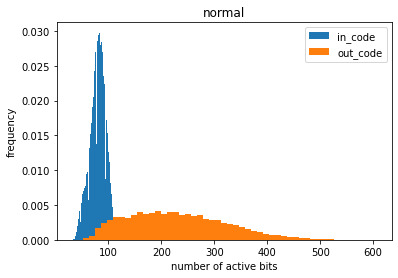

(30000,)
(30000,)


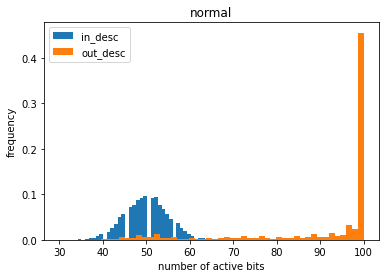

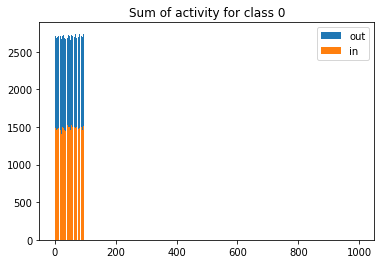

In [56]:
plot_retrival(in_normal, out_normal, lbls[:n_stored], t="normal", plots=[1,1,1])

In [24]:
""" Create clean desCodes (patterns to store in the memory) """
tst_descs = noisy_x_hot_encoding(tst_lbls, nxh_x, nxh_Pc, nxh_Pr)
tst_desCodes = join(tst_descs, tst_codes)

In [25]:
""" Visualize how the sparsity of unseen retrieval works"""
in_tst = tst_desCodes
out_tst = wn_desCodes.retrieve(in_tst)

(10000,)
(10000,)


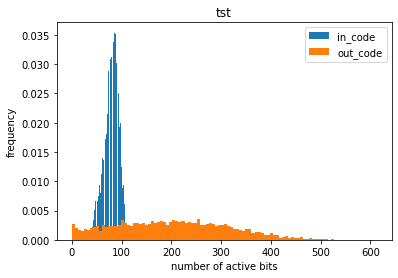

(10000,)
(10000,)


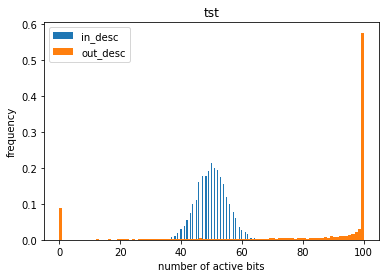

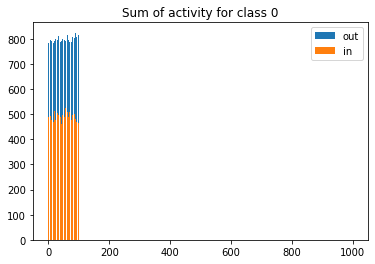

In [41]:
plot_retrival(in_tst, out_tst, tst_lbls, t="tst")

In [37]:
empty_desCodes_trn = delete_descs(desCodes[:n_stored], desc_size)
in_cla_trn = empty_desCodes_trn
out_cla_trn = wn_desCodes.retrieve(in_cla_trn)

In [50]:
""" out_cla_trn_descs, out_cla_trn_codes = separate(out_cla_trn, desc_size)
print(avg_bits_per_code(csr_matrix(out_cla_trn_descs[0])))
print(avg_bits_per_code(out_cla_trn_codes)) """

121.0
231.84003333333334


(30000,)
(30000,)


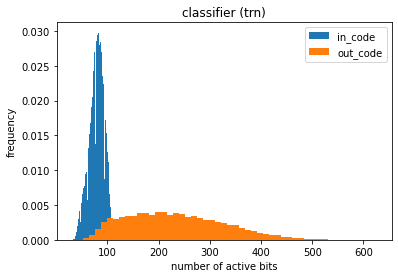

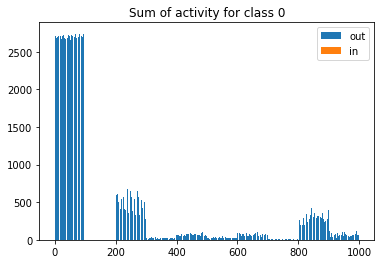

In [57]:
plot_retrival(in_cla_trn, out_cla_trn, lbls[:n_stored], t="classifier (trn)", plots=[1,0,1])

In [58]:
empty_desCodes_tst = delete_descs(tst_desCodes, desc_size)
in_cla_tst = empty_desCodes_tst
out_cla_tst = wn_desCodes.retrieve(in_cla_tst)

(10000,)
(10000,)


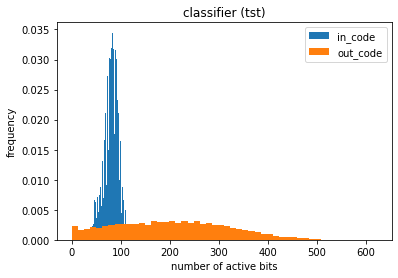

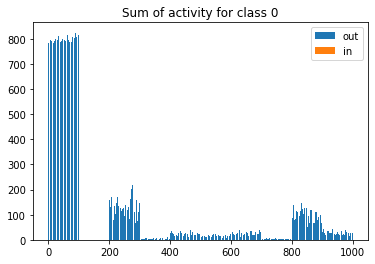

In [59]:
plot_retrival(in_cla_tst, out_cla_tst, tst_lbls, t="classifier (tst)", plots=[1,0,1])

adding noise: 100%|██████████| 10000/10000 [00:03<00:00, 3152.72data-sample/s]


(10000,)
(10000,)


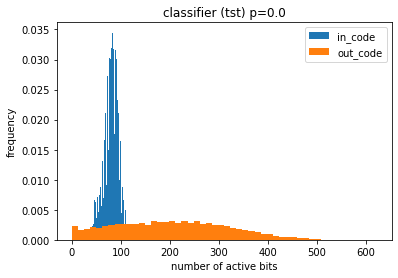

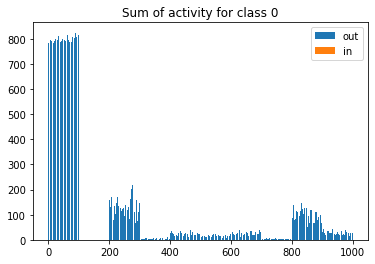

0.8329


adding noise: 100%|██████████| 10000/10000 [00:04<00:00, 2424.25data-sample/s]


(10000,)
(10000,)


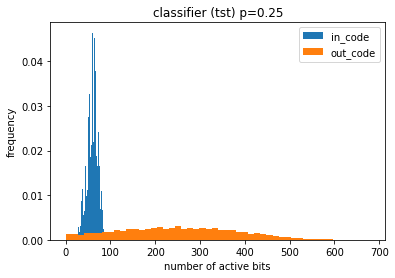

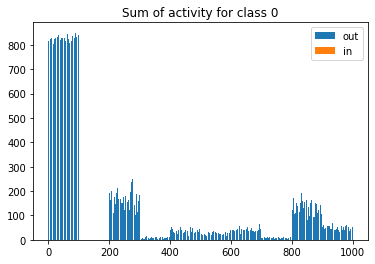

0.8249


adding noise: 100%|██████████| 10000/10000 [00:05<00:00, 1945.29data-sample/s]


(10000,)
(10000,)


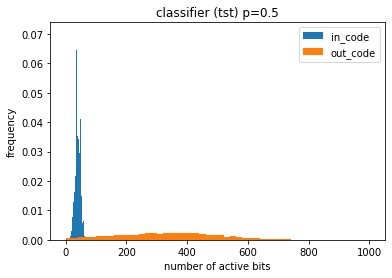

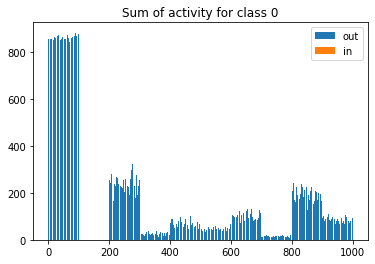

0.802


In [66]:
for prob in [0.0, 0.25, 0.5]:
    tst_codes_noisy = add_zero_noise(tst_codes, prob)
    tst_desCodes_noisy = join(tst_descs, tst_codes_noisy)
    empty_tst_desCodes_noisy = delete_descs(tst_desCodes_noisy, desc_size)
    in_cla_tst = empty_tst_desCodes_noisy
    out_cla_tst = wn_desCodes.retrieve(in_cla_tst)
    predictions = separate(out_cla_tst, desc_size)[0]
    plot_retrival(in_cla_tst, out_cla_tst, tst_lbls, t=f"classifier (tst) p={prob}", plots=[1,0,1])
    tst_acc = interval_classifier(predictions, tst_lbls, nxh_x)
    print(tst_acc)